<a href="https://colab.research.google.com/github/thunderunibolt/Aptos-test/blob/main/Diabetic%20Retinopathy%20%20(256%20x%20256).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image
from PIL import UnidentifiedImageError

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
import itertools

import warnings
warnings.filterwarnings('ignore')

In [5]:
Healthy = os.listdir('/content/drive/MyDrive/Original Images/archive/Healthy')
Mild = os.listdir('/content/drive/MyDrive/Original Images/archive/Mild DR')
Moderate = os.listdir('/content/drive/MyDrive/Original Images/archive/Moderate DR')
Proliferate = os.listdir('/content/drive/MyDrive/Original Images/archive/Proliferate DR')
Severe = os.listdir('/content/drive/MyDrive/Original Images/archive/Severe DR')

In [2]:
img_w, img_h = 225, 225
X = []
y = []

In [6]:
for i in Healthy:
    try:
        img = Image.open("/content/drive/MyDrive/Original Images/archive/Healthy/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError:
        pass

In [8]:
for i in Mild:
    try:
        img = Image.open("/content/drive/MyDrive/Original Images/archive/Mild DR/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass

In [9]:
for i in Moderate:
    try:
        img = Image.open("/content/drive/MyDrive/Original Images/archive/Moderate DR/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass

In [10]:
for i in Proliferate:
    try:
        img = Image.open("/content/drive/MyDrive/Original Images/archive/Proliferate DR/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass

In [11]:
for i in Severe:
    try:
        img = Image.open("/content/drive/MyDrive/Original Images/archive/Severe DR/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass

In [12]:
X = np.asarray(X)
y = np.asarray(y)
print(X.shape, y.shape)

(2750, 225, 225, 3) (2750,)


In [13]:
x = X.astype('float32')
x /= 255

In [14]:
num_classes = 3

labels = keras.utils.to_categorical(y, num_classes)
print(labels[0])

[1. 0. 0.]


In [15]:
x_train1, x_test, y_train1, y_test = train_test_split(x, labels, test_size = 0.1, random_state=5)
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,test_size=0.1,random_state=5)

print('Number of train: {}'.format(len(x_train)))
print('Number of validation: {}'.format(len(x_val)))
print('Number of test: {}'.format(len(x_test)))

Number of train: 2227
Number of validation: 248
Number of test: 275


In [16]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20.,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=30.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=0.2,
    vertical_flip=0.2,
    rescale=None)

datagen.fit(x_train)

In [17]:
base_model = tf.keras.applications.InceptionV3(input_shape=(225,225,3),include_top=False,weights="imagenet")

87910968/87910968 [==============================] - 0s 0us/step


In [18]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [19]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 28373411 (108.24 MB)
Trainable params: 657

In [21]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 3*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [22]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [23]:
lrd = ReduceLROnPlateau(monitor = 'recall',patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-6)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=10)

In [24]:
model.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)


In [25]:
%time
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: user 0 ns, sys: 45 µs, total: 45 µs
Wall time: 90.4 µs
Epoch 1/20
70/70 [==============================] - 23s 267ms/step - loss: 1.8384 - accuracy: 0.6866 - precision: 0.6912 - recall: 0.6785 - auc: 0.8401 - f1_score: 1.0247 - val_loss: 0.6087 - val_accuracy: 0.7823 - val_precision: 0.7878 - val_recall: 0.7782 - val_auc: 0.9293 - val_f1_score: 1.1755 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 17s 237ms/step - loss: 0.4332 - accuracy: 0.8307 - precision: 0.8327 - recall: 0.8267 - auc: 0.9477 - f1_score: 1.2442 - val_loss: 0.9454 - val_accuracy: 0.7863 - val_precision: 0.7895 - val_recall: 0.7863 - val_auc: 0.9021 - val_f1_score: 1.1850 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 17s 238ms/step - loss: 0.3793 - accuracy: 0.8496 - precision: 0.8508 - recall: 0.8478 - auc: 0.9608 - f1_score: 1.2747 - val_loss: 0.6583 - val_accuracy: 0.7903 - val_precision: 0.7903 - val_recall: 0.7903 - val_auc: 0.9336 - val_f1_score: 1.1816 - lr: 0.001

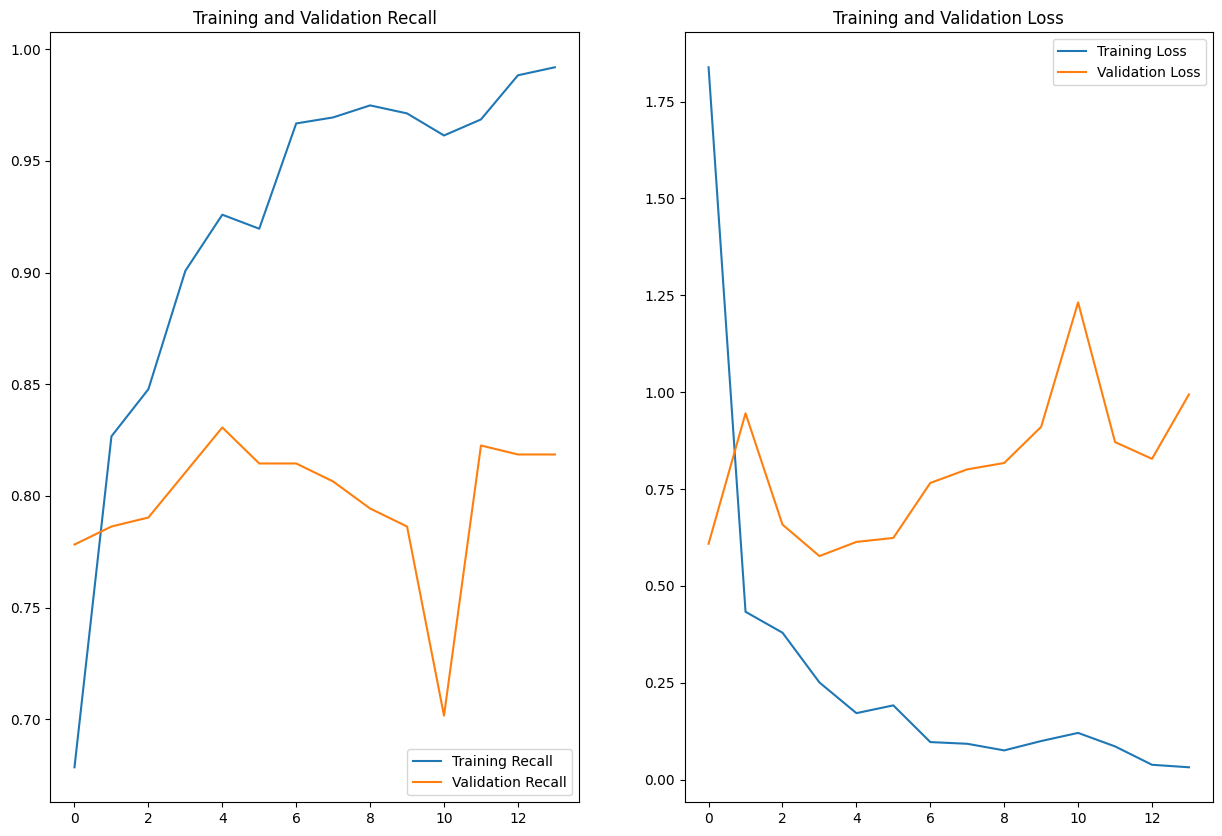

In [26]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Recall')
plt.plot(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

9/9 [==============================] - 2s 184ms/step
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Healty       0.94      0.96      0.95        95
     Caution       0.77      0.95      0.85       129
      Severe       0.94      0.33      0.49        51

    accuracy                           0.84       275
   macro avg       0.88      0.75      0.76       275
weighted avg       0.86      0.84      0.82       275



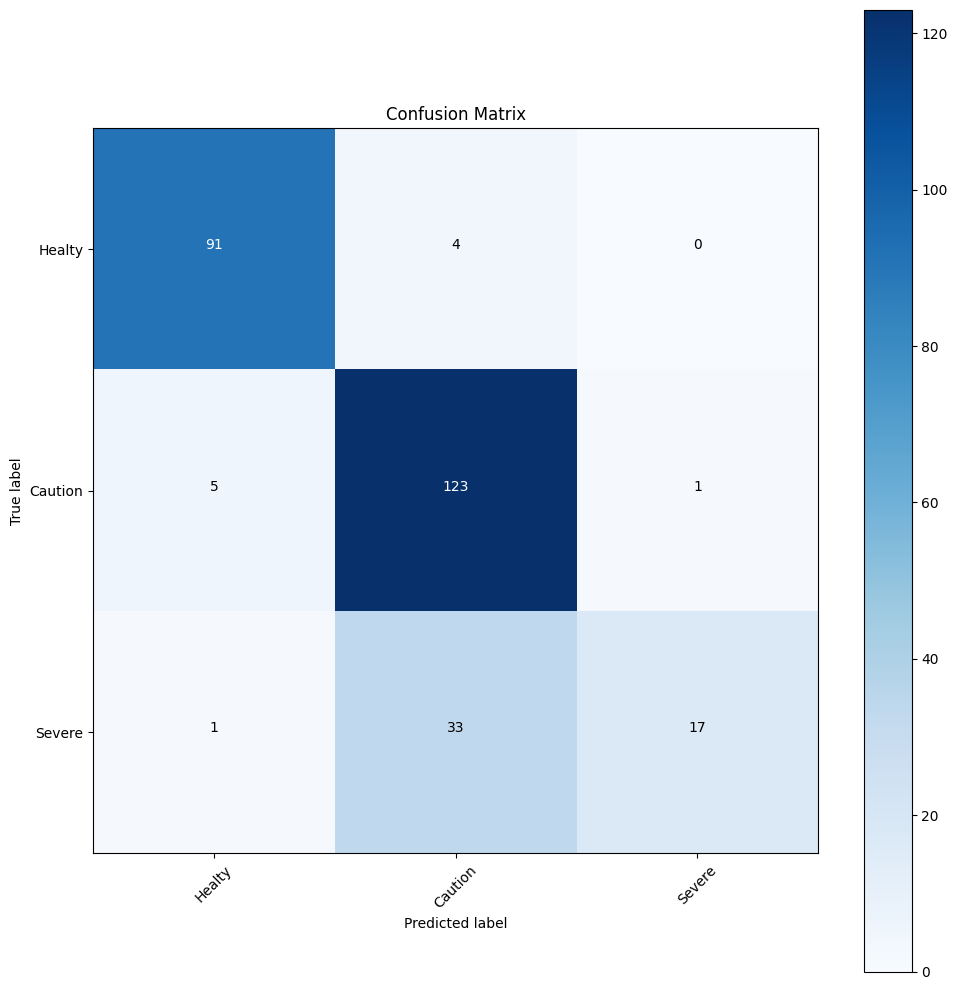

In [28]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")

y_test_c = np.argmax(y_test, axis=1)
target_names = ["Healty", "Caution", "Severe"]

Y_pred = np.argmax(model.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))

In [29]:
model.save('CNN DR2.h5')

In [41]:
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# Define the custom f1_score function (if needed)
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# Step 1: Upload the images you want to classify
uploaded = files.upload()

# Step 2: Load the model from the directory, including the custom metric
model = load_model('/content/CNN DR2.h5', custom_objects={'f1_score': f1_score})

# Step 3: Loop over the uploaded images, preprocess, and predict
for img_name in uploaded.keys():
    # Load and preprocess the image
    img = image.load_img(img_name, target_size=(225, 225))  # Adjust target_size to the model's expected input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image if necessary

    # Step 4: Make a prediction
    predictions = model.predict(img_array)

    # Step 5: Interpret the result
    class_labels = ['Healthy', 'Caution', 'Severe']  # Updated to match your three classes
    predicted_class = np.argmax(predictions, axis=1)
    print(f'Image: {img_name} -> Predicted class: {class_labels[predicted_class[0]]}')


Saving Healthy.png to Healthy (2).png
Saving Moderate_DR_2.png to Moderate_DR_2.png
Saving Severe DR_5.png to Severe DR_5 (3).png
1/1 [==============================] - 1s 1s/step
Image: Healthy (2).png -> Predicted class: Healthy
1/1 [==============================] - 0s 61ms/step
Image: Moderate_DR_2.png -> Predicted class: Caution
1/1 [==============================] - 0s 61ms/step
Image: Severe DR_5 (3).png -> Predicted class: Severe
